In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
np.random.seed(42)


In [2]:
def safe_div(numer, denom):
    """Avoid division-by-zero; returns NaN if denom is 0."""
    return np.where(denom == 0, np.nan, numer / denom)

def compute_financial_kpis(df):
    """
    Required columns:
    revenue, cogs, operating_expenses, cash_inflow, cash_outflow,
    current_assets, current_liabilities, recurring_revenue
    """
    out = df.copy()

    out["gross_profit"] = out["revenue"] - out["cogs"]
    out["gross_margin"] = safe_div(out["gross_profit"], out["revenue"])
    
    out["operating_profit"] = out["gross_profit"] - out["operating_expenses"]
    out["net_profit"] = out["operating_profit"]  # simplified; add taxes/interest if you have them
    out["net_margin"] = safe_div(out["net_profit"], out["revenue"])

    out["cash_flow"] = out["cash_inflow"] - out["cash_outflow"]
    out["cash_flow_margin"] = safe_div(out["cash_flow"], out["revenue"])

    out["current_ratio"] = safe_div(out["current_assets"], out["current_liabilities"])
    out["recurring_revenue_share"] = safe_div(out["recurring_revenue"], out["revenue"])
    return out

def compute_customer_market_kpis(df):
    """
    Required columns:
    nps, churn_rate, brand_score, market_share, market_share_prev, uvp_score
    """
    out = df.copy()
    out["market_share_growth"] = out["market_share"] - out["market_share_prev"]
    return out

def compute_ops_people_kpis(df):
    """
    Required columns:
    efficiency_score, roadmap_score, analytics_score, adaptability_score,
    employee_turnover, engagement_score, training_hours, leadership_score
    """
    return df.copy()


In [3]:
def minmax_score(series, higher_is_better=True):
    """Convert a numeric series to 0-100 scale using min-max normalization."""
    s = series.astype(float)
    mn, mx = np.nanmin(s), np.nanmax(s)
    if np.isclose(mx, mn):
        return pd.Series(np.where(np.isnan(s), np.nan, 50.0), index=series.index)  # flat score if no variation
    norm = (s - mn) / (mx - mn)
    if not higher_is_better:
        norm = 1 - norm
    return pd.Series(100 * norm, index=series.index)

def build_health_score(df):
    """
    Takes a dataframe with KPI columns and creates category scores + overall score.
    You can adjust weights any time.
    """
    out = df.copy()

    # Financial signals (higher is better unless noted)
    out["s_net_margin"] = minmax_score(out["net_margin"], True)
    out["s_cash_flow"] = minmax_score(out["cash_flow"], True)
    out["s_current_ratio"] = minmax_score(out["current_ratio"], True)
    out["s_recurring_share"] = minmax_score(out["recurring_revenue_share"], True)

    # Customer/market
    out["s_nps"] = minmax_score(out["nps"], True)
    out["s_churn"] = minmax_score(out["churn_rate"], False)  # lower churn is better
    out["s_brand"] = minmax_score(out["brand_score"], True)
    out["s_mkt_growth"] = minmax_score(out["market_share_growth"], True)
    out["s_uvp"] = minmax_score(out["uvp_score"], True)

    # Ops/strategy
    out["s_efficiency"] = minmax_score(out["efficiency_score"], True)
    out["s_roadmap"] = minmax_score(out["roadmap_score"], True)
    out["s_analytics"] = minmax_score(out["analytics_score"], True)
    out["s_adapt"] = minmax_score(out["adaptability_score"], True)

    # People/culture
    out["s_turnover"] = minmax_score(out["employee_turnover"], False)  # lower turnover is better
    out["s_engagement"] = minmax_score(out["engagement_score"], True)
    out["s_training"] = minmax_score(out["training_hours"], True)
    out["s_leadership"] = minmax_score(out["leadership_score"], True)

    # Category scores (simple averages)
    out["financial_score"] = out[["s_net_margin", "s_cash_flow", "s_current_ratio", "s_recurring_share"]].mean(axis=1)
    out["customer_market_score"] = out[["s_nps", "s_churn", "s_brand", "s_mkt_growth", "s_uvp"]].mean(axis=1)
    out["ops_strategy_score"] = out[["s_efficiency", "s_roadmap", "s_analytics", "s_adapt"]].mean(axis=1)
    out["people_culture_score"] = out[["s_turnover", "s_engagement", "s_training", "s_leadership"]].mean(axis=1)

    # Overall weights (edit these)
    weights = {
        "financial_score": 0.35,
        "customer_market_score": 0.25,
        "ops_strategy_score": 0.20,
        "people_culture_score": 0.20
    }

    out["overall_health_score"] = (
        out["financial_score"] * weights["financial_score"] +
        out["customer_market_score"] * weights["customer_market_score"] +
        out["ops_strategy_score"] * weights["ops_strategy_score"] +
        out["people_culture_score"] * weights["people_culture_score"]
    )

    return out, weights


In [4]:
def make_sample_youth_wrestling_clubs(n=20):
    clubs = [f"Youth Wrestling Club {i:02d}" for i in range(1, n+1)]
    regions = np.random.choice(["London", "North West", "West Midlands", "Yorkshire", "Scotland", "Wales", "South West"], size=n)

    revenue = np.random.randint(60_000, 450_000, size=n)
    cogs = (revenue * np.random.uniform(0.25, 0.55, size=n)).astype(int)
    operating_expenses = (revenue * np.random.uniform(0.25, 0.50, size=n)).astype(int)

    cash_inflow = (revenue * np.random.uniform(0.90, 1.05, size=n)).astype(int)
    cash_outflow = (revenue * np.random.uniform(0.80, 1.00, size=n)).astype(int)

    current_assets = np.random.randint(10_000, 120_000, size=n)
    current_liabilities = np.random.randint(5_000, 90_000, size=n)

    recurring_revenue = (revenue * np.random.uniform(0.30, 0.85, size=n)).astype(int)

    # Customer/market
    nps = np.random.randint(10, 80, size=n)  # -100..100 in real life; keeping simple
    churn_rate = np.random.uniform(0.03, 0.25, size=n)  # monthly/annual depending on your definition
    brand_score = np.random.uniform(40, 95, size=n)     # proxy index
    market_share_prev = np.random.uniform(0.002, 0.030, size=n)
    market_share = np.clip(market_share_prev + np.random.uniform(-0.003, 0.006, size=n), 0, None)
    uvp_score = np.random.uniform(45, 95, size=n)       # proxy rating

    # Ops/strategy & People/culture
    efficiency_score = np.random.uniform(40, 95, size=n)
    roadmap_score = np.random.uniform(30, 95, size=n)
    analytics_score = np.random.uniform(20, 95, size=n)
    adaptability_score = np.random.uniform(30, 95, size=n)

    employee_turnover = np.random.uniform(0.02, 0.35, size=n)  # annual turnover as fraction
    engagement_score = np.random.uniform(45, 95, size=n)
    training_hours = np.random.uniform(5, 60, size=n)          # per staff/year
    leadership_score = np.random.uniform(45, 95, size=n)

    df = pd.DataFrame({
        "club_type": "Youth Wrestling",
        "name": clubs,
        "region": regions,
        "revenue": revenue,
        "cogs": cogs,
        "operating_expenses": operating_expenses,
        "cash_inflow": cash_inflow,
        "cash_outflow": cash_outflow,
        "current_assets": current_assets,
        "current_liabilities": current_liabilities,
        "recurring_revenue": recurring_revenue,

        "nps": nps,
        "churn_rate": churn_rate,
        "brand_score": brand_score,
        "market_share_prev": market_share_prev,
        "market_share": market_share,
        "uvp_score": uvp_score,

        "efficiency_score": efficiency_score,
        "roadmap_score": roadmap_score,
        "analytics_score": analytics_score,
        "adaptability_score": adaptability_score,

        "employee_turnover": employee_turnover,
        "engagement_score": engagement_score,
        "training_hours": training_hours,
        "leadership_score": leadership_score
    })
    return df

df_wrestling = make_sample_youth_wrestling_clubs(n=25)
df_wrestling.head()


,club_type,name,region,revenue,cogs,operating_expenses,cash_inflow,cash_outflow,current_assets,current_liabilities,recurring_revenue,nps,churn_rate,brand_score,market_share_prev,market_share,uvp_score,efficiency_score,roadmap_score,analytics_score,adaptability_score,employee_turnover,engagement_score,training_hours,leadership_score
0,Youth Wrestling,Youth Wrestling Club 01,South West,274176,73894,81977,260367,260771,108098,5854,184427,28,0.216829,40.850114,0.010221,0.008364,57.512145,61.917760,34.508485,45.560266,78.904344,0.288224,93.161127,30.503412,52.520845
1,Youth Wrestling,Youth Wrestling Club 02,Yorkshire,244779,130874,63962,222634,207024,23545,43623,75666,57,0.174675,91.057521,0.024662,0.026362,72.461333,73.871755,36.550570,89.806799,81.452638,0.332592,45.607724,24.434373,74.706536
2,Youth Wrestling,Youth Wrestling Club 03,Scotland,407449,219895,135001,385710,332232,76199,12392,236993,12,0.155028,63.550128,0.024683,0.028613,80.729796,74.930151,31.184419,84.380956,81.325179,0.345380,93.493941,37.101086,64.044543
3,Youth Wrestling,Youth Wrestling Club 04,South West,318795,157012,110675,302465,273510,44766,60680,135351,29,0.050608,93.166015,0.026278,0.025220,78.009869,42.491721,36.138792,52.174552,35.928397,0.268615,47.157996,9.275405,93.495720
4,Youth Wrestling,Youth Wrestling Club 05,West Midlands,216730,73988,68884,218776,180372,83530,51717,141924,33,0.110897,92.999099,0.027571,0.030177,58.996695,60.603694,74.395440,76.315330,62.137320,0.144166,89.557156,58.591714,87.105946


In [5]:
def make_sample_boxing_areas(n=20):
    gyms = [f"Boxing Club {i:02d}" for i in range(1, n+1)]
    areas = np.random.choice(["London", "Manchester", "Birmingham", "Leeds", "Glasgow", "Cardiff", "Bristol"], size=n)

    revenue = np.random.randint(80_000, 750_000, size=n)
    cogs = (revenue * np.random.uniform(0.20, 0.50, size=n)).astype(int)
    operating_expenses = (revenue * np.random.uniform(0.25, 0.55, size=n)).astype(int)

    cash_inflow = (revenue * np.random.uniform(0.92, 1.08, size=n)).astype(int)
    cash_outflow = (revenue * np.random.uniform(0.82, 1.03, size=n)).astype(int)

    current_assets = np.random.randint(15_000, 160_000, size=n)
    current_liabilities = np.random.randint(8_000, 120_000, size=n)

    recurring_revenue = (revenue * np.random.uniform(0.35, 0.90, size=n)).astype(int)

    nps = np.random.randint(5, 85, size=n)
    churn_rate = np.random.uniform(0.04, 0.30, size=n)
    brand_score = np.random.uniform(35, 98, size=n)
    market_share_prev = np.random.uniform(0.002, 0.040, size=n)
    market_share = np.clip(market_share_prev + np.random.uniform(-0.004, 0.008, size=n), 0, None)
    uvp_score = np.random.uniform(40, 98, size=n)

    efficiency_score = np.random.uniform(35, 98, size=n)
    roadmap_score = np.random.uniform(25, 98, size=n)
    analytics_score = np.random.uniform(15, 98, size=n)
    adaptability_score = np.random.uniform(25, 98, size=n)

    employee_turnover = np.random.uniform(0.03, 0.45, size=n)
    engagement_score = np.random.uniform(40, 98, size=n)
    training_hours = np.random.uniform(5, 70, size=n)
    leadership_score = np.random.uniform(40, 98, size=n)

    df = pd.DataFrame({
        "club_type": "Boxing",
        "name": gyms,
        "region": areas,
        "revenue": revenue,
        "cogs": cogs,
        "operating_expenses": operating_expenses,
        "cash_inflow": cash_inflow,
        "cash_outflow": cash_outflow,
        "current_assets": current_assets,
        "current_liabilities": current_liabilities,
        "recurring_revenue": recurring_revenue,

        "nps": nps,
        "churn_rate": churn_rate,
        "brand_score": brand_score,
        "market_share_prev": market_share_prev,
        "market_share": market_share,
        "uvp_score": uvp_score,

        "efficiency_score": efficiency_score,
        "roadmap_score": roadmap_score,
        "analytics_score": analytics_score,
        "adaptability_score": adaptability_score,

        "employee_turnover": employee_turnover,
        "engagement_score": engagement_score,
        "training_hours": training_hours,
        "leadership_score": leadership_score
    })
    return df

df_boxing = make_sample_boxing_areas(n=25)
df_boxing.head()


,club_type,name,region,revenue,cogs,operating_expenses,cash_inflow,cash_outflow,current_assets,current_liabilities,recurring_revenue,nps,churn_rate,brand_score,market_share_prev,market_share,uvp_score,efficiency_score,roadmap_score,analytics_score,adaptability_score,employee_turnover,engagement_score,training_hours,leadership_score
0,Boxing,Boxing Club 01,Manchester,124238,30329,41442,123493,115888,31389,9917,97757,18,0.168810,80.119282,0.033937,0.040890,61.908105,66.846996,70.607573,50.001427,55.808632,0.229180,76.959432,28.705321,45.135518
1,Boxing,Boxing Club 02,Leeds,81252,38836,24627,84469,76639,137177,28618,33206,36,0.232780,72.738850,0.036606,0.035585,88.520759,72.488086,49.518208,25.978926,50.832610,0.174641,96.873454,41.444018,42.180613
2,Boxing,Boxing Club 03,Bristol,565450,196570,156409,523532,552185,56427,40254,462481,55,0.189019,87.088326,0.006667,0.009598,74.072309,56.374088,85.232835,89.747501,94.979784,0.177647,92.395101,36.269022,67.827317
3,Boxing,Boxing Club 04,Bristol,395826,109831,113281,380147,360458,137883,113292,300940,42,0.299400,95.421712,0.010964,0.008951,57.054591,70.874942,51.503322,72.371414,38.459077,0.203373,77.506565,62.524893,73.683918
4,Boxing,Boxing Club 05,Manchester,401638,135649,155929,415348,340103,146189,55362,230815,27,0.235625,56.579028,0.008290,0.004696,81.415434,90.910010,27.498652,71.704260,31.594598,0.326069,80.204162,39.467234,55.757844


In [6]:
def full_pipeline(df):
    df1 = compute_financial_kpis(df)
    df2 = compute_customer_market_kpis(df1)
    df3 = compute_ops_people_kpis(df2)
    scored, weights = build_health_score(df3)
    return scored, weights

wrestling_scored, wrestling_weights = full_pipeline(df_wrestling)
boxing_scored, boxing_weights = full_pipeline(df_boxing)

wrestling_weights, boxing_weights


({'financial_score': 0.35,
  'customer_market_score': 0.25,
  'ops_strategy_score': 0.2,
  'people_culture_score': 0.2},
 {'financial_score': 0.35,
  'customer_market_score': 0.25,
  'ops_strategy_score': 0.2,
  'people_culture_score': 0.2})

In [7]:
def top_ranked(df_scored, top_n=10):
    cols = [
        "name", "region",
        "overall_health_score",
        "financial_score", "customer_market_score", "ops_strategy_score", "people_culture_score",
        "revenue", "net_profit", "net_margin", "cash_flow", "current_ratio", "recurring_revenue_share",
        "nps", "churn_rate", "brand_score", "market_share_growth", "uvp_score"
    ]
    return df_scored.sort_values("overall_health_score", ascending=False)[cols].head(top_n)

print("Top Youth Wrestling Clubs (sample):")
display(top_ranked(wrestling_scored, 10))

print("\nTop Boxing Clubs/Areas (sample):")
display(top_ranked(boxing_scored, 10))


Top Youth Wrestling Clubs (sample):


,name,region,overall_health_score,financial_score,customer_market_score,ops_strategy_score,people_culture_score,revenue,net_profit,net_margin,cash_flow,current_ratio,recurring_revenue_share,nps,churn_rate,brand_score,market_share_growth,uvp_score
12,Youth Wrestling Club 13,West Midlands,61.823686,45.318583,74.335297,46.453941,90.437848,189981,33370,0.175649,20476,1.170695,0.808581,75,0.140580,91.488513,0.001647,82.892306
4,Youth Wrestling Club 05,West Midlands,61.311979,53.746471,56.899773,57.845887,83.532967,216730,73858,0.340783,38404,1.615136,0.654842,33,0.110897,92.999099,0.002606,58.996695
22,Youth Wrestling Club 23,North West,55.047104,53.061622,46.069209,67.652736,57.138435,63890,18635,0.291673,8560,4.986672,0.795226,57,0.239864,78.335866,0.000681,68.673589
14,Youth Wrestling Club 15,Yorkshire,53.270837,31.954877,49.717732,71.502127,76.783857,441490,157528,0.356810,-357,1.632903,0.441867,44,0.138354,71.353364,0.004157,50.803632
16,Youth Wrestling Club 17,Wales,52.922216,44.169866,38.541293,55.383693,83.753506,379030,50079,0.132124,31006,1.897274,0.749471,50,0.188939,73.825397,0.000951,47.036440
24,Youth Wrestling Club 25,Scotland,52.329213,60.008986,32.985999,50.049627,65.348213,316840,100638,0.317630,37113,13.341314,0.486466,17,0.111435,59.772013,-0.001592,66.692582
21,Youth Wrestling Club 22,Wales,51.351226,58.446886,45.368569,46.993433,50.769932,391236,55531,0.141937,68426,1.687450,0.793467,30,0.236901,80.742274,0.003264,69.580794
2,Youth Wrestling Club 03,Scotland,50.149186,48.720596,47.560342,58.523744,47.510715,407449,52553,0.128981,53478,6.149048,0.581651,12,0.155028,63.550128,0.003930,80.729796
8,Youth Wrestling Club 09,North West,50.145447,44.582827,63.073661,52.529291,41.335922,190523,62438,0.327719,-10737,1.044695,0.815198,45,0.116481,86.812517,0.001866,75.586037
5,Youth Wrestling Club 06,Scotland,50.144893,25.846746,69.064131,37.177027,81.985469,406622,107151,0.263515,3942,1.853900,0.395901,63,0.088345,86.915520,-0.002232,92.743264



Top Boxing Clubs/Areas (sample):


,name,region,overall_health_score,financial_score,customer_market_score,ops_strategy_score,people_culture_score,revenue,net_profit,net_margin,cash_flow,current_ratio,recurring_revenue_share,nps,churn_rate,brand_score,market_share_growth,uvp_score
12,Boxing Club 13,Leeds,65.231392,75.643032,44.666156,87.694731,50.254226,535102,260627,0.487060,49904,6.019571,0.779833,55,0.066758,51.128979,0.001508,44.379195
9,Boxing Club 10,Birmingham,64.277485,58.994137,60.483261,59.834559,82.709047,397537,185318,0.466165,38484,0.175715,0.859545,70,0.225657,92.446702,-0.001448,84.390664
14,Boxing Club 15,Cardiff,60.399332,65.845978,59.153342,49.885353,62.939169,556467,129151,0.232091,39571,8.472868,0.762775,55,0.138494,72.356663,0.006328,55.793508
2,Boxing Club 03,Bristol,59.347614,45.375648,61.171894,77.783280,63.082538,565450,212471,0.375756,-28653,1.401774,0.817899,55,0.189019,87.088326,0.002932,74.072309
5,Boxing Club 06,Manchester,56.862029,70.974075,42.004290,76.349228,31.250923,685605,133070,0.194091,125904,5.005973,0.863115,67,0.223815,49.323112,-0.000262,70.603568
19,Boxing Club 20,Birmingham,56.184691,58.768473,60.941470,53.281245,48.620545,543389,191521,0.352457,111980,1.219574,0.698566,55,0.166453,76.036134,0.000768,88.707754
17,Boxing Club 18,Cardiff,55.845992,49.929902,65.086719,44.642978,65.851254,384462,78600,0.204442,43529,8.491008,0.452521,71,0.170595,84.775332,-0.000405,86.443487
22,Boxing Club 23,Bristol,55.712573,51.271114,54.335380,73.125615,47.793577,647376,224612,0.346958,75173,1.065059,0.673568,68,0.043173,39.342057,0.000193,71.999911
11,Boxing Club 12,Manchester,53.478289,38.053649,45.380585,77.122938,66.948889,630222,203541,0.322967,7299,5.275063,0.376451,57,0.236205,41.350060,0.007706,59.393043
21,Boxing Club 22,London,51.059599,45.066849,45.718586,76.387731,42.895045,333490,129115,0.387163,63966,1.182715,0.523908,46,0.240689,58.589428,0.005597,63.663101


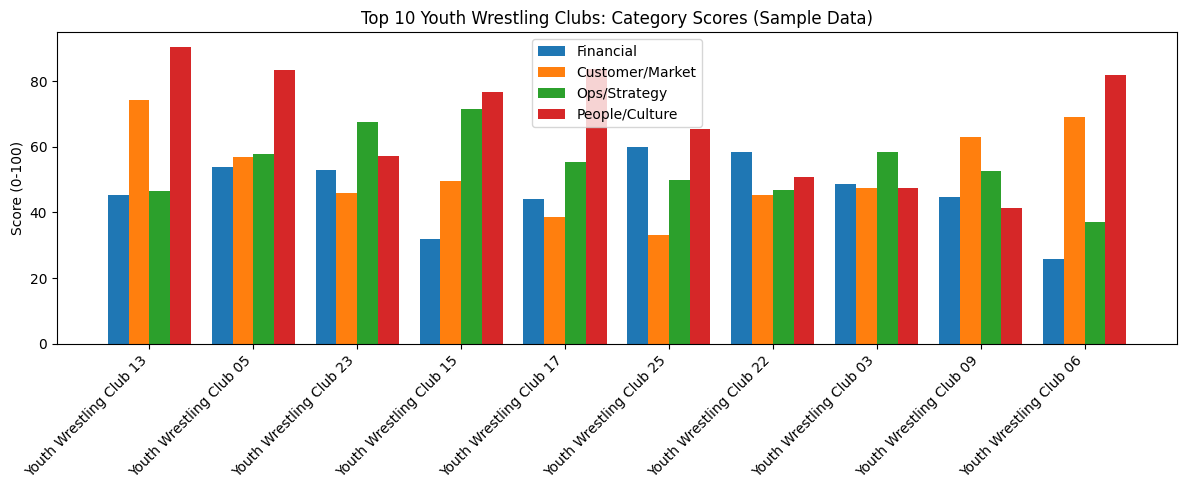

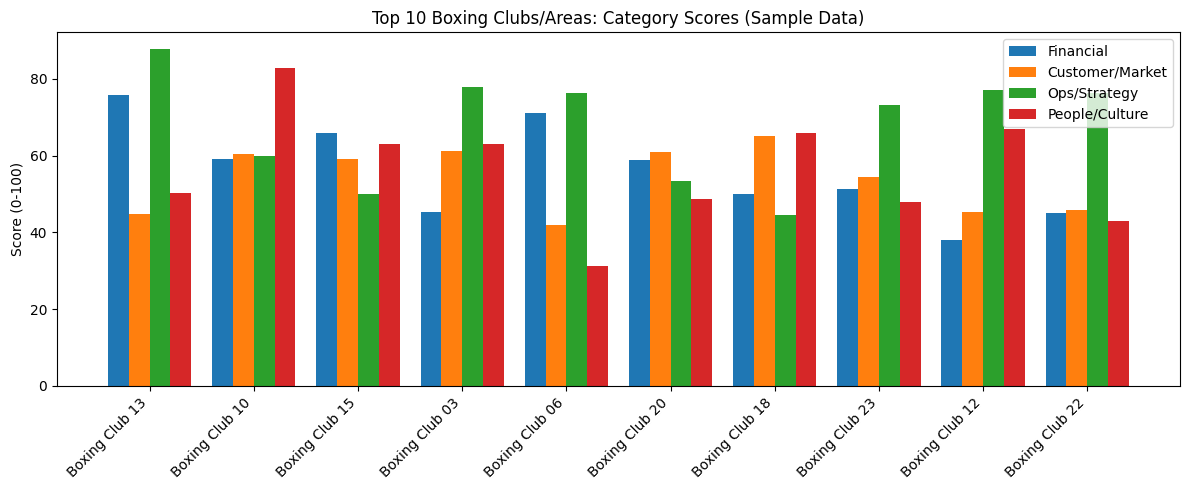

In [8]:
def plot_category_scores(df_scored, title):
    dfp = df_scored.sort_values("overall_health_score", ascending=False).head(10)
    x = np.arange(len(dfp))
    width = 0.2

    plt.figure(figsize=(12, 5))
    plt.bar(x - 1.5*width, dfp["financial_score"], width, label="Financial")
    plt.bar(x - 0.5*width, dfp["customer_market_score"], width, label="Customer/Market")
    plt.bar(x + 0.5*width, dfp["ops_strategy_score"], width, label="Ops/Strategy")
    plt.bar(x + 1.5*width, dfp["people_culture_score"], width, label="People/Culture")

    plt.xticks(x, dfp["name"], rotation=45, ha="right")
    plt.ylabel("Score (0-100)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_category_scores(wrestling_scored, "Top 10 Youth Wrestling Clubs: Category Scores (Sample Data)")
plot_category_scores(boxing_scored, "Top 10 Boxing Clubs/Areas: Category Scores (Sample Data)")


In [9]:
def risk_flags(df_scored):
    out = df_scored.copy()

    out["flag_low_margin"] = out["net_margin"] < 0.05
    out["flag_negative_cashflow"] = out["cash_flow"] < 0
    out["flag_weak_current_ratio"] = out["current_ratio"] < 1.0
    out["flag_low_recurring"] = out["recurring_revenue_share"] < 0.35

    out["flag_low_nps"] = out["nps"] < 20
    out["flag_high_churn"] = out["churn_rate"] > 0.20

    out["flag_high_turnover"] = out["employee_turnover"] > 0.25
    out["flag_low_engagement"] = out["engagement_score"] < 55

    flags = [c for c in out.columns if c.startswith("flag_")]
    out["risk_flag_count"] = out[flags].sum(axis=1)

    cols = ["name", "region", "overall_health_score", "risk_flag_count"] + flags
    return out.sort_values(["risk_flag_count", "overall_health_score"], ascending=[False, True])[cols]

print("Youth Wrestling Clubs: risk flags (sample):")
display(risk_flags(wrestling_scored).head(15))

print("\nBoxing Clubs/Areas: risk flags (sample):")
display(risk_flags(boxing_scored).head(15))


Youth Wrestling Clubs: risk flags (sample):


,name,region,overall_health_score,risk_flag_count,flag_low_margin,flag_negative_cashflow,flag_weak_current_ratio,flag_low_recurring,flag_low_nps,flag_high_churn,flag_high_turnover,flag_low_engagement
23,Youth Wrestling Club 24,Yorkshire,31.343831,4,True,False,True,False,False,True,True,False
1,Youth Wrestling Club 02,Yorkshire,39.402775,4,False,False,True,True,False,False,True,True
3,Youth Wrestling Club 04,South West,34.247902,3,False,False,True,False,False,False,True,True
0,Youth Wrestling Club 01,South West,44.858493,3,False,True,False,False,False,True,True,False
20,Youth Wrestling Club 21,Wales,37.127614,2,False,True,False,False,False,False,True,False
9,Youth Wrestling Club 10,West Midlands,39.476978,2,False,False,False,False,False,True,True,False
18,Youth Wrestling Club 19,North West,43.023680,2,True,False,False,False,False,False,True,False
7,Youth Wrestling Club 08,South West,43.811620,2,False,False,False,False,False,True,False,True
2,Youth Wrestling Club 03,Scotland,50.149186,2,False,False,False,False,True,False,True,False
24,Youth Wrestling Club 25,Scotland,52.329213,2,False,False,False,False,True,False,False,True



Boxing Clubs/Areas: risk flags (sample):


,name,region,overall_health_score,risk_flag_count,flag_low_margin,flag_negative_cashflow,flag_weak_current_ratio,flag_low_recurring,flag_low_nps,flag_high_churn,flag_high_turnover,flag_low_engagement
23,Boxing Club 24,Bristol,37.621381,3,False,False,True,False,True,False,True,False
10,Boxing Club 11,Birmingham,39.909079,3,False,True,True,False,False,False,True,False
24,Boxing Club 25,Bristol,40.011623,3,False,True,True,False,False,False,True,False
16,Boxing Club 17,Glasgow,43.091579,3,False,False,False,False,True,False,True,True
5,Boxing Club 06,Manchester,56.862029,3,False,False,False,False,False,True,True,True
4,Boxing Club 05,Manchester,41.222761,2,False,False,False,False,False,True,True,False
8,Boxing Club 09,Cardiff,44.864714,2,False,True,True,False,False,False,False,False
6,Boxing Club 07,Manchester,45.617883,2,False,False,False,False,True,True,False,False
7,Boxing Club 08,Cardiff,47.133360,2,False,False,True,False,False,False,False,True
15,Boxing Club 16,Leeds,49.440117,2,False,False,False,False,False,False,True,True


In [10]:
# Example:
# df_real = pd.read_csv("your_file.csv")

# Required minimum columns to match this notebook:
required_cols = [
    "name","region",
    "revenue","cogs","operating_expenses","cash_inflow","cash_outflow",
    "current_assets","current_liabilities","recurring_revenue",
    "nps","churn_rate","brand_score","market_share_prev","market_share","uvp_score",
    "efficiency_score","roadmap_score","analytics_score","adaptability_score",
    "employee_turnover","engagement_score","training_hours","leadership_score"
]

# Validate:
def validate_columns(df, required_cols):
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return True

# Usage:
# validate_columns(df_real, required_cols)
# scored_real, weights = full_pipeline(df_real)
# display(top_ranked(scored_real, 10))
